In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
import trackpy as tp
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import linregress

from src.Segmentation3D import *
from src.Correlations import pairwise_autocorrelation

In [3]:
vox_to_um = get_voxel_size_35mm()

In [4]:
# TOMOCUBE
file = "A2P1"
folder = "../../data/Tomocube/MDCK_10.02.2025/"
df = pd.read_csv(f"{folder}{file}/area_volume_filtered.csv")

# track cells
tracks_raw = tp.link(df, search_range=50, memory=5)
tracks = tp.filter_stubs(tracks_raw, 5)
tracks = tracks.reset_index(drop=True)

Frame 39: 989 trajectories present.


In [5]:
# Subtract trend from volume
std_V  = 0
tracks['V_fluct'] = {}
tracks['dV'] = {}

for p in np.unique(tracks.particle):
    df_tmp = tracks[tracks.particle == p]

    fit = linregress(df_tmp.frame, df_tmp.V)
    lin_fit = fit.intercept + df_tmp.frame*fit.slope
    V_fluct = df_tmp.V-lin_fit

    tracks.loc[tracks['particle']==p, 'V_fluct'] = V_fluct
    tracks.loc[tracks['particle']==p, 'dV'] = np.concatenate([[0], np.diff(df_tmp.V)])

In [6]:
r_arr, C_arr = pairwise_autocorrelation(tracks, 'dV', vox_to_um)

/tmp/ipykernel_132886/1354750631.py:16: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


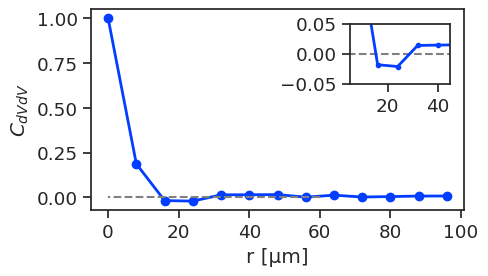

In [11]:
mask =  (r_arr < 100)

fig, ax = plt.subplots(1,1, figsize=(5,3))
sns.set_theme(style='ticks', palette='bright', font_scale=1.2)

ax.plot(r_arr[mask], C_arr[mask] / C_arr[0], 'o-', lw=2)
ax.hlines(0, 60, 0, linestyle="dashed", color="gray")
ax.set(xlabel="r [µm]", ylabel=r"$C_{dVdV}$")

left, bottom, width, height = [0.7, 0.68, 0.2, 0.2]
inset = fig.add_axes([left, bottom, width, height])
inset.hlines(0, 60, 0, linestyle="dashed", color="gray")
inset.plot(r_arr, C_arr / C_arr[0], '.-', lw=2)
inset.set(xlim=(5, 45), ylim=(-0.05, 0.05))

fig.tight_layout()

In [12]:
fig.savefig("../../figs/volume/autocorrelation_deltaV.png", dpi=300)